In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.palettes import Spectral3
from bokeh.layouts import gridplot
from bokeh.plotting import figure, output_notebook, show
import random
import geopandas 
import scipy
from shapely.geometry import Point,Polygon
import folium
from sklearn.preprocessing import StandardScaler,LabelEncoder
import pandas_profiling
import cufflinks as cfc
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import scipy.stats as sc
import pickle
pd.set_option('Display.max_columns',None)

In [2]:
f = 'train.csv'
num_lines = sum(1 for l in open(f))
size = int(num_lines/2)
skip_idx = random.sample(range(1,num_lines),num_lines-size)

df = pd.read_csv('train.csv',skiprows = skip_idx)

In [3]:
df.profile_report()

In [4]:
m = folium.Map(location=[40.767937, -73.982155], tiles='Stamen Toner',
    zoom_start=13)

In [5]:
cfc.go_offline()
cfc.set_config_file(offline=False, world_readable=True)

In [6]:
df['vendor_id'] = df['vendor_id'].astype(np.uint8)
df['pickup_longitude'] = df['pickup_longitude'].astype(np.float32)
df['passenger_count'] = df['passenger_count'].astype(np.uint8)
df['pickup_latitude'] = df['pickup_latitude'].astype(np.float32)
df['dropoff_longitude'] = df['dropoff_longitude'].astype(np.float32)
df['dropoff_latitude'] = df['dropoff_latitude'].astype(np.float32)
df['trip_duration'] = df['trip_duration'].astype(np.int32)

In [7]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['dropoff_hour'] = df['dropoff_datetime'].dt.hour
df['dropoff_day'] = df['dropoff_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

In [8]:
df['pickup_hour'] = df['pickup_hour'].astype(np.uint8)
df['pickup_day'] = df['pickup_day'].astype(np.uint8)
df['dropoff_hour'] = df['dropoff_hour'].astype(np.uint8)
df['dropoff_day'] = df['dropoff_day'].astype(np.uint8)
df['month'] = df['month'].astype(np.uint8)

In [16]:
print('Data size after column updates:',round(df.memory_usage().sum()/2**20,2),'MB')

Data size after column updates: 24.34 MB


In [9]:
df.profile_report()

In [8]:
df.groupby('vendor_id').agg({'pickup_day':'value_counts'}).unstack(level = 'vendor_id').iplot(kind = 'bar')

In [9]:
df.groupby('pickup_hour')['trip_duration'].count().iplot(kind= 'bar')

In [10]:
df.groupby('pickup_hour')['trip_duration'].mean().iplot(kind= 'bar')

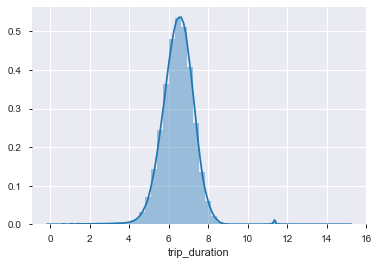

In [12]:
sns.distplot(np.log(df['trip_duration']))

In [10]:
df['log_trip_duration'] = np.log(df['trip_duration'])
df['log_trip_duration'] = df['log_trip_duration'].astype(np.float32)
df.drop(columns = 'trip_duration',inplace = True)

In [11]:
df.dtypes

id                            object
vendor_id                      uint8
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                uint8
pickup_longitude             float32
pickup_latitude              float32
dropoff_longitude            float32
dropoff_latitude             float32
store_and_fwd_flag            object
pickup_hour                    uint8
pickup_day                     uint8
dropoff_hour                   uint8
dropoff_day                    uint8
month                          uint8
log_trip_duration            float32
dtype: object

In [12]:
df.drop(columns=['id','pickup_datetime','dropoff_datetime'],inplace=True)

In [ ]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [13]:
def cluster_locations(data,map):
    km_pickup = KMeans(n_clusters = 20, random_state= 42)
    km_pickup.fit(data[['pickup_longitude','pickup_latitude']])
    km_dropoff = KMeans(n_clusters=20, random_state= 42)
    km_dropoff.fit(data[['dropoff_longitude','dropoff_latitude']])
    df_pickup = pd.DataFrame(km_pickup.cluster_centers_.tolist(),columns = ['pickup_longitude','pickup_latitude'])
    df_dropoff = pd.DataFrame(km_dropoff.cluster_centers_.tolist(),columns = ['dropoff_longitude','dropoff_latitude'])
    for lat,long in zip(df_pickup['pickup_latitude'],df_pickup['pickup_longitude']):
        folium.Marker([lat,long]).add_to(m)
    for lat,long in zip(df_dropoff['dropoff_latitude'],df_dropoff['dropoff_longitude']):
        folium.Marker([lat,long],icon = folium.Icon(color = 'red')).add_to(m)
    return m

In [62]:
X = df.drop(columns='log_trip_duration')
y = df['log_trip_duration']

In [15]:
cluster_locations(X,m)

In [28]:
def num_features(dataset):
    '''
    Extract numerical features from dataset

    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.

    Returns
    -------
    numeric_data : Dataframe
        DESCRIPTION.

    '''
    numeric_data = dataset.select_dtypes(exclude = 'object')
    return numeric_data

def cat_features(dataset):
    '''
    Extract categorical features from dataset

    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.

    Returns
    -------
    categorical_data : Dataframe
        DESCRIPTION.

    '''
    categorical_data = dataset.select_dtypes(include = 'object')
    return categorical_data

def one_hot_encode(dataset):
    '''
    OneHotEncode Categorical features and drop first class for each feature

    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.

    Returns
    -------
    dataset : Dataframe
        DESCRIPTION.

    '''
    dataset = pd.get_dummies(dataset,drop_first = True)
    return dataset

def std_scaler(dataset):
    '''
    Scale numerical features with mean =0 and Std. deviation =1

    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.

    Returns
    -------
    dataset : Dataframe
        DESCRIPTION.

    '''
    scaler = StandardScaler()
    dataset = pd.DataFrame(scaler.fit_transform(dataset),columns=dataset.columns.tolist(),index = dataset.index.tolist())
    return dataset

def lbl_encoder(dataset):
    '''
    label encode categorical features

    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.

    Returns
    -------
    dataset : Dataframe
        DESCRIPTION.

    '''
    label = LabelEncoder()
    #dataset = pd.DataFrame(label.fit_transform(dataset),columns=dataset.columns.tolist(),index = dataset.index.tolist())
    cat_columns = dataset.select_dtypes(include='object').columns.tolist()
    try:
        for i in cat_columns:
            dataset[i] = label.fit_transform(dataset[i])
    except :
        print('Encoding error ',i)
    #print(dataset)
    return dataset

def build_dataset(dataset,encode_type = 0):
    '''
    OneHotEncode categorical data if encode type = 1
    Label Encode categorical data if encode type = 0

    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.
    encode_type : int32, optional
        DESCRIPTION. The default is 0.

    Returns
    -------
    ds_new : Dataframe
        DESCRIPTION.

    '''
    try:
        num_feature = num_features(dataset)
        cat_feature = cat_features(dataset) 
        if encode_type == 1:
            num = std_scaler(num_feature)
            cat = one_hot_encode(cat_feature)
        else:
            num = std_scaler(num_feature)
            cat = lbl_encoder(cat_feature)

        ds_new = pd.concat([num,cat],axis = 1)
        return ds_new
    except Exception as e:
        print('Build Dataset failed \n',+str(e.message()))
         
def run_model(dataset,target,model):
    '''
    Build dataset based on distance based model or tree based model.
    Split data into test and train with test size of 20%.
    Fit the model to training set.
    Predict the output on testing set.
    Generate Classification report, Confusion Matrix, Accuracy score.
    Plot Area under Curve for the model.
    Parameters
    ----------
    dataset : Dataframe
        DESCRIPTION.
    target : Series
        DESCRIPTION.
    model : TYPE
        models from sklearn package.

    Returns
    -------
    None.

    '''
    'for Distance Based models'
    if (model.__class__ == LinearRegression) or (model.__class__ ==Ridge):      
        X_new = build_dataset(dataset,1)
    else:
        X_new = build_dataset(dataset)         
    print(X_new.shape)
    X_train,X_test,y_train,y_test = train_test_split(X_new,target,random_state = 42, test_size =0.25)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('===='*20)
    print(type(model))
    print('===='*20)
    print('Score :',model.score(X_test,y_test))
    return model,X_train.columns.tolist()
      


In [63]:
X.drop(columns =['dropoff_hour','dropoff_day'],inplace = True)

In [20]:
lin=LinearRegression()
model,feature_list = run_model(X,y,lin)

(729321, 12)
<class 'sklearn.linear_model._base.LinearRegression'>
Score : 0.04616622085329525


In [24]:
ridge = ridge = Ridge(alpha = 0.1,random_state=42)
model,feature_list = run_model(X,y,lin)

(729321, 12)
<class 'sklearn.linear_model._base.LinearRegression'>
Score : 0.04616622085329525


In [27]:
dtr = DecisionTreeRegressor(random_state=42,min_samples_split=5)
model,feature_list = run_model(X,y,dtr)

(729321, 12)
<class 'sklearn.tree._classes.DecisionTreeRegressor'>
Score : 0.4735207658883659


In [21]:
rfr = RandomForestRegressor(n_estimators=100,random_state=42)

In [22]:
model,feature_list = run_model(X,y,rfr)

(729321, 11)
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Score : 0.7255994492594771


In [24]:
feature_importance_rfr = pd.Series(model.feature_importances_.tolist(),index = feature_list).sort_values(ascending = False)

In [25]:
feature_importance_rfr

pickup_latitude       0.244272
pickup_longitude      0.225383
dropoff_longitude     0.210855
dropoff_latitude      0.189698
pickup_hour           0.036385
dropoff_hour          0.030882
pickup_day            0.027319
month                 0.018297
passenger_count       0.010643
vendor_id             0.005571
store_and_fwd_flag    0.000694
dtype: float64

In [70]:
def run_model_with_pca(dataset,target,model,pca):
    if (model.__class__ == LinearRegression) or (model.__class__ ==Ridge):      
        X_new = build_dataset(dataset,1)
    else:
        X_new = build_dataset(dataset)         
    print(X_new.shape)
    X_train,X_test,y_train,y_test = train_test_split(X_new,target,random_state = 42, test_size =0.25)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print(pca.explained_variance_ratio_)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('===='*20)
    print(type(model))
    print('===='*20)
    print('Score :',model.score(X_test,y_test))

In [34]:
rfr = RandomForestRegressor(n_estimators=50,random_state=42)
pca = PCA(n_components=9,random_state = 42)
run_model_with_pca(X,y,rfr,pca)

(729321, 11)
[0.24143906 0.18326374 0.1304443  0.12103009 0.09467232 0.09162173
 0.06682554 0.05254938 0.01147927 0.00616239 0.00051219]
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Score : 0.7393145887452327


TypeError: 'NoneType' object is not iterable

In [36]:
rfr = RandomForestRegressor(n_estimators=100,random_state=42)
run_model_with_pca(X,y,rfr)

(729321, 11)
[0.24143906 0.18326374 0.1304443  0.12103009 0.09467232 0.09162173
 0.06682554 0.05254938 0.01147927]
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Score : 0.7212530844493397


In [72]:
rfr = RandomForestRegressor(n_estimators=100,random_state=42,min_samples_leaf=3)
pca = PCA(n_components=9,random_state = 42)
run_model_with_pca(X,y,rfr,pca)

(729321, 10)
[0.26644085 0.14441861 0.13362307 0.11206096 0.1038227  0.09467446
 0.07373839 0.05798764 0.01266809]
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Score : 0.7189470025038226


In [82]:
pickle.dump(rfr,open('rf_model.pkl','wb'))

In [83]:
gbr = GradientBoostingRegressor(random_state=42)
pca = PCA(n_components=9,random_state = 42)
run_model_with_pca(X,y,gbr,pca)

(729321, 10)
[0.26644085 0.14441861 0.13362307 0.11206096 0.1038227  0.09467446
 0.07373839 0.05798764 0.01266809]
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Score : 0.6165764756447395


In [87]:
gbr = GradientBoostingRegressor(alpha=0.5,random_state=42)
run_model(X,y,gbr)

(729321, 10)
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Score : 0.42891376326069214


(GradientBoostingRegressor(alpha=0.5, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 ['vendor_id',
  'passenger_count',
  'pickup_longitude',
  'pickup_latitude',
  'dropoff_longitude',
  'dropoff_latitude',
  'pickup_hour',
  'pickup_day',
  'month',
  'store_and_fwd_flag'])

In [53]:
df_test = pd.read_csv('test.csv')

In [54]:
df_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [55]:
df_test['vendor_id'] = df_test['vendor_id'].astype(np.uint8)
df_test['pickup_longitude'] = df_test['pickup_longitude'].astype(np.float32)
df_test['passenger_count'] = df_test['passenger_count'].astype(np.uint8)
df_test['pickup_latitude'] = df_test['pickup_latitude'].astype(np.float32)
df_test['dropoff_longitude'] = df_test['dropoff_longitude'].astype(np.float32)
df_test['dropoff_latitude'] = df_test['dropoff_latitude'].astype(np.float32)

In [56]:
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test['pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test['pickup_day'] = df_test['pickup_datetime'].dt.dayofweek
df_test['month'] = df_test['pickup_datetime'].dt.month

In [57]:
df_test['pickup_hour'] = df_test['pickup_hour'].astype(np.uint8)
df_test['pickup_day'] = df_test['pickup_day'].astype(np.uint8)
df_test['month'] = df_test['month'].astype(np.uint8)

In [61]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 10 columns):
vendor_id             625134 non-null uint8
passenger_count       625134 non-null uint8
pickup_longitude      625134 non-null float32
pickup_latitude       625134 non-null float32
dropoff_longitude     625134 non-null float32
dropoff_latitude      625134 non-null float32
store_and_fwd_flag    625134 non-null object
pickup_hour           625134 non-null uint8
pickup_day            625134 non-null uint8
month                 625134 non-null uint8
dtypes: float32(4), object(1), uint8(5)
memory usage: 17.3+ MB


In [59]:
id = df_test['id']

In [60]:
df_test.drop(columns=['id','pickup_datetime'],inplace = True)

In [66]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 10 columns):
vendor_id             625134 non-null uint8
passenger_count       625134 non-null uint8
pickup_longitude      625134 non-null float32
pickup_latitude       625134 non-null float32
dropoff_longitude     625134 non-null float32
dropoff_latitude      625134 non-null float32
store_and_fwd_flag    625134 non-null object
pickup_hour           625134 non-null uint8
pickup_day            625134 non-null uint8
month                 625134 non-null uint8
dtypes: float32(4), object(1), uint8(5)
memory usage: 17.3+ MB


In [73]:
X_test = build_dataset(df_test)
X_test = pca.transform(X_test)
y_pred = rfr.predict(X_test)

In [76]:
y_1 = np.exp(y_pred) 

In [77]:
y_1

array([1044.18207411,  380.9551686 ,  440.57171879, ..., 1881.81777172,
       1952.5733537 , 1182.81856902])

In [81]:
submission_data = pd.Series(y_1,index = id,name = 'trip_duration')
submission_data.to_csv('Submission.csv',header = submission_data.name,index = True)